In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord

In [2]:
# Age option 3 APOKASC-3 Pinsonneault et al. 2025
#Reading in the table, making sure all the tables have a column named Age in Gyr
# and that every star in the table has an Age
apokasc3raw= Table.read("Pinsonneault2025.txt", format="ascii.cds")
#in this case there were two age columns, one for Red Clump and one for Red Giant Branch so we combine them
ageRC=np.array(apokasc3raw['AgeRC']*(apokasc3raw['EvolState']=='RC'))
rcnans=np.isnan(ageRC) #removing nans from this version of the table.
ageRC[rcnans]=0
ageRGB=np.array(apokasc3raw['AgeRGB']*(apokasc3raw['EvolState']=='RGB'))
rgbnans=np.isnan(ageRGB) #removing nans from this version of the table.
ageRGB[rgbnans]=0
apokasc3raw['Age']=(ageRC+ageRGB)

hasagea3=np.where((apokasc3raw['Age']==apokasc3raw['Age']) & (apokasc3raw['Age']>0.1))
apokasc3=apokasc3raw[hasagea3]
apokasc3

KIC,EvolState,ESSource,CatTab,SeisSource,SpecSource,NNumax,NDNu,Nquar,Numax,e_Numax,DNu,e_DNu,FDNu,e_FDNu,FNumax,Mass,e_Mass,Radius,e_Radius,logg-Seis,e_logg-Seis,Teff,e_Teff,logg-Spec,e_logg-Spec,[Fe/H],e_[Fe/H],[a/Fe],e_[a/Fe],[C/Fe],e_[C/Fe],[N/Fe],e_[N/Fe],InvRGaia,e_InvRGaia,AgeCat,AgeRGB,E_AgeRGB,e_AgeRGB,AgeRC,E_AgeRC,e_AgeRC,vsini,alphaCat,GaiaDR3,2MASS,Age
,,,,,,,,,uHz,uHz,uHz,uHz,,,,Msun,Msun,Rsun,Rsun,dex(cm / s2),dex(cm / s2),K,K,dex(cm / s2),dex(cm / s2),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),dex(---),,,,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,km / s,,,,
int64,str7,str4,str8,str4,str4,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str5,int64,str23,float64
893214,RGB,Seis,Gold,WAvg,DR17,8,5,15,40.5841,0.2874,4.3254,0.0289,1.0277,0.005,0.9976,1.4404,0.0602,11.0014,0.2055,2.5146,0.0042,4718.9233,44.7811,2.4559,0.058,-0.2617,0.058,0.0815,0.022,-0.0626,0.0135,0.2483,0.0164,0.082389,0.002866,RGB,2.8815,0.298,-0.2639,2.8815,0.298,-0.2639,0.0,Apoor,2050237616959273728,2MASS J19245967+3638183,2.8815
1026180,RC,Spec,Gold,WAvg,DR17,8,5,4,35.6089,0.2338,3.9208,0.0265,0.9972,0.005,0.9936,1.5334,0.0633,12.2361,0.2278,2.4512,0.0039,4576.1016,40.5161,2.4066,0.058,0.2741,0.058,0.0215,0.022,0.0568,0.0084,0.3647,0.0107,0.085599,0.002161,RC,--,--,--,3.1325,0.2754,-0.1905,0.0,Apoor,2050237174589477888,2MASS J19241923+3645378,3.1325
1026309,RGB,Seis,Silver,WAvg,DR17,8,4,18,16.6974,0.5675,1.9432,0.0805,1.0072,0.005,1.0205,2.642,0.518,23.2678,2.0993,2.1176,0.0148,4479.2246,39.7068,2.2388,0.058,0.1609,0.058,-0.0295,0.022,-0.0823,0.0088,0.2913,0.011,0.047943,0.001239,RGB_AGB,0.5842,0.1481,-0.109,0.7082,0.1832,-0.1405,0.0,Apoor,2050236934071312384,2MASS J19242636+3643594,0.5842
1026452,RC,Seis,Gold,WAvg,DR17,8,5,18,34.3652,0.2256,3.9749,0.0268,0.9953,0.005,0.9936,1.4618,0.0599,11.9485,0.2215,2.451,0.0044,4910.6035,53.0693,2.4907,0.058,-0.2652,0.058,0.0658,0.022,0.0005,0.0189,0.1605,0.0222,0.075937,0.003795,RC,--,--,--,2.6495,0.2319,-0.1919,0.0,Apoor,2050243050104808960,2MASS J19243452+3647244,2.6495
1027110,RGB,Seis,Silver,WAvg,DR17,8,4,18,6.5198,0.1616,1.1613,0.044,1.0511,0.005,1.0535,1.0367,0.1769,23.337,1.8791,1.6949,0.011,4194.4375,37.9582,1.7495,0.058,-0.3017,0.058,0.2615,0.022,0.1451,0.0109,0.1366,0.0131,0.040245,0.001509,RGB_AGB,9.0694,8.0551,-3.8133,7.2088,4.6171,-2.3475,0.0,Arich,2050239201814200192,2MASS J19250937+3644599,9.0694
1027337,RGB,Seis,Gold,WAvg,DR17,9,6,18,74.3689,0.4491,6.9661,0.0418,1.0282,0.005,0.9959,1.2676,0.0489,7.6702,0.133,2.7732,0.0038,4621.996,41.3674,2.7836,0.058,0.2081,0.058,0.0354,0.022,0.062,0.009,0.2898,0.0115,0.123008,0.0033,RGB,5.8519,0.5953,-0.5247,5.8519,0.5953,-0.5247,0.0,Apoor,2050240782362231552,2MASS J19252021+3647118,5.8519
1027707,RGB,Seis,Silver,WAvg,DR17,6,3,18,3.0206,0.0885,0.5593,0.0309,1.0265,0.005,1.0663,2.0033,0.4792,48.0566,5.5208,1.3484,0.0129,3961.365,35.9864,1.4062,0.058,0.1105,0.058,0.0356,0.022,0.0455,0.0079,0.1751,0.0094,0.018104,0.001509,RGB_AGB,1.3052,0.6198,-0.3779,1.5494,0.4593,-0.4138,0.0,Apoor,2050240129527252096,2MASS J19253846+3646103,1.3052
1160655,RGB,Seis,Silver,WAvg,DR17,5,2,18,1.5726,0.0502,0.3698,0.024,1.0608,0.005,1.0525,1.1903,0.3305,52.0838,6.9807,1.058,0.0139,3837.788,33.9314,0.9088,0.058,-0.1446,0.058,0.1098,0.022,0.0582,0.0089,0.2023,0.0105,0.018767,0.001236,RGB_AGB,5.7073,8.7454,-2.777,5.013,5.3362,-2.0267,0.0,Arich,2050252395953454464,2MASS J19232193+3650379,5.7073


In [3]:
#Pick from any of the previous 4 options
agedata= apokasc3

In [4]:
print('Answer: There are '+str(len(agedata))+' targets with ages in agedata.')

Answer: There are 12291 targets with ages in agedata.


In [9]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [11]:
filename='astraAllStarASPCAP-0.6.0.fits'
tb = fits.open(filename)
data = tb[2].data

In [13]:
mask_gaia = (data['zgr_plx']>0)

In [15]:
data_masked=data[mask_gaia]

In [17]:
apok3_gaia = apokasc3['GaiaDR3']
dr19_gaia = data_masked['gaia_dr3_source_id']
print(apok3_gaia[:5])
print(dr19_gaia[:5])

      GaiaDR3      
-------------------
2050237616959273728
2050237174589477888
2050236934071312384
2050243050104808960
2050239201814200192
[4184200643505162112 4184125807991900928 4184137077986034048
 4183930438518525184  538028216707715712]


In [19]:
lookup = {dr19_gaia[i]: i for i in range(len(dr19_gaia))}

In [21]:
#Option 3 APOKASC-3 Pinsonneault et al. 2025
intersect, ind_a, ind_b = np.intersect1d(data_masked['gaia_dr3_source_id'],agedata['GaiaDR3'], return_indices=True) 

In [23]:
matched_apok3_rows = []
matched_dr19_indices = []
for row in apokasc3:
    gid = row['GaiaDR3']
    if gid in lookup:
        matched_apok3_rows.append(row)
        matched_dr19_indices.append(lookup[gid])

In [25]:
apokasc3_matched = Table(rows=matched_apok3_rows, names=apokasc3.colnames)
idx = np.array(matched_dr19_indices)

In [26]:
print("Matched APOKASC-3 stars:", len(apokasc3_matched))

Matched APOKASC-3 stars: 11909


In [29]:
fullx = np.dstack([data_masked['teff'][idx],data_masked['logg'][idx], data_masked['m_h_atm'][idx],
                   data_masked['alpha_m_atm'][idx], data_masked['c_h'][idx], data_masked['n_h'][idx]])[0]

fully = np.dstack([apokasc3_matched['Age']])[0] #for APOKASC-3 seismic ages

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y
apok3_ids = apokasc3_matched['KIC']

In [31]:
tenpercent = len(fully) // 10

trainbin = slice(0, -1*tenpercent-1)
testing  = slice(-1*tenpercent, -1)

x_train, y_train = fullx[trainbin], fully[trainbin]
x_test,  y_test  = fullx[testing], fully[testing]

# Model A

In [34]:
neurons_per_layer_A = 32
layers_A = 10
iterations_A = 150

In [36]:
inputs = keras.Input(shape=(6,))
x = inputs
for i in range(layers_A):
    x = keras.layers.Dense(neurons_per_layer_A, activation='relu')(x)

outputs_A = keras.layers.Dense(1)(x)
modelA = keras.Model(inputs=inputs, outputs=outputs_A)
modelA.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,761 (38.13 KB)

 Trainable params: 9,761 (38.13 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
modelA.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [42]:
modelA.fit(x_train, y_train, epochs=iterations_A, validation_split=0.05, batch_size=300)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0543e-04 - loss: 0.4922 - val_accuracy: 0.0000e+00 - val_loss: 0.3034
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0543e-04 - loss: 0.4850 - val_accuracy: 0.0000e+00 - val_loss: 0.2985
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0543e-04 - loss: 0.5226 - val_accuracy: 0.0000e+00 - val_loss: 0.3291
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0543e-04 - loss: 0.5038 - val_accuracy: 0.0000e+00 - val_loss: 0.3147
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0543e-04 - loss: 0.4875 - val_accuracy: 0.0000e+00 - val_loss: 0.3053
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0543e-04 - loss: 0.4910 - val_accuracy: 0.0000e+00 - val_loss: 0.2851
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0543e-04 - loss: 0.4806 - val_accuracy: 0.0000e+00 - val_loss: 0.3041
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [44]:
predictionsA = modelA.predict(x_test)
print(len(predictionsA))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1108


In [46]:
metric = 0.3

goodfitA = np.where(((1 - metric) < predictionsA / y_test) & ((1 + metric) > predictionsA / y_test))
badfitA  = np.where(((1 - metric) > predictionsA / y_test) | ((1 + metric) < predictionsA / y_test))

print('With', neurons_per_layer_A, 'neurons per layer,', layers_A, 'layers, and', iterations_A, 'iterations')
print('using the training set', trainbin)
print(len(goodfitA[0]) / len(y_test) * 100, 'percent of the ages are good')
print(len(badfitA[0]) / len(y_test) * 100,  'percent of the ages are bad')

With 32 neurons per layer, 10 layers, and 150 iterations
using the training set slice(0, -1110, None)
64.98194945848375 percent of the ages are good
35.018050541516246 percent of the ages are bad


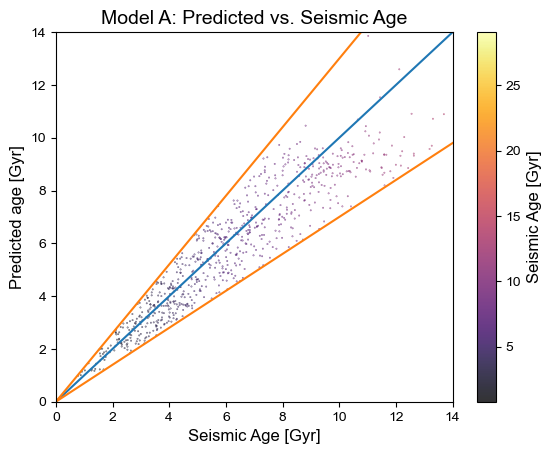

In [62]:
plt.scatter((y_test[goodfitA] * scaling_y), (predictionsA[goodfitA] * scaling_y), s=0.1, c = (y_test[goodfitA] * scaling_y)
            , cmap= 'inferno', alpha=0.8)
plt.xlim(0., 14.)
plt.plot([0., 14.], [0., 14.])
plt.plot([14, 0, 14], [14 * (1 - metric), 0, 14 * (1 + metric)])
plt.ylabel(r'Predicted age [Gyr]')
plt.xlabel(r'Seismic Age [Gyr]')
plt.ylim(0, 14)
plt.title('Model A: Predicted vs. Seismic Age')
cbar = plt.colorbar()
cbar.set_label("Seismic Age [Gyr]")
plt.savefig("ModelA_Predicted_vs_SeismicAge.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Model B

In [65]:
neurons_per_layer_B = 64
layers_B = 5
iterations_B = 120

In [67]:
inputs = keras.Input(shape=(6,))
x = inputs
for i in range(layers_B):
    x = keras.layers.Dense(neurons_per_layer_B, activation='relu')(x)

outputs_B = keras.layers.Dense(1)(x)
modelB = keras.Model(inputs=inputs, outputs=outputs_B, name='modelB')
modelB.summary()

Model: "modelB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
modelB.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [71]:
tenpercent = len(agedata['Age'][ind_b]) // 10
trainbin = slice(0, -1*tenpercent-1)
testing  = slice(-1*tenpercent, -1)
x_train_B, y_train_B = fullx[trainbin], fully[trainbin]
x_test_B,  y_test_B  = fullx[testing],  fully[testing]

In [73]:
modelB.fit(x_train_B, y_train_B, epochs=iterations_B, validation_split=0.05, batch_size=300)

Epoch 1/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - loss: 1.0902 - val_accuracy: 0.0000e+00 - val_loss: 0.5658
Epoch 2/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0629e-04 - loss: 0.7038 - val_accuracy: 0.0000e+00 - val_loss: 0.4118
Epoch 3/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0629e-04 - loss: 0.6128 - val_accuracy: 0.0000e+00 - val_loss: 0.3894
Epoch 4/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0629e-04 - loss: 0.5968 - val_accuracy: 0.0000e+00 - val_loss: 0.3922
Epoch 5/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0629e-04 - loss: 0.5881 - val_accuracy: 0.0000e+00 - val_loss: 0.3905
Epoch 6/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0629e-04 - loss: 0.5819 - val_accuracy: 0.0000e+00 - val_loss: 0.3856
Epoch 7/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0629e-04 - loss: 0.5803 - val_accuracy: 0.0000e+00 - val_loss: 0.3854
Epoch 8/120
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

In [75]:
predictionsB = modelB.predict(x_test_B)
print(len(predictionsB))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1189


In [77]:
metric = 0.3

goodfitB = np.where( ((1 - metric) < predictionsB / y_test_B) & ((1 + metric) > predictionsB / y_test_B) )
badfitB  = np.where( ((1 - metric) > predictionsB / y_test_B) | ((1 + metric) < predictionsB / y_test_B) )

print('With', neurons_per_layer_B, 'neurons per layer,', layers_B, 'layers, and', iterations_B, 'iterations')
print('using the training set', trainbin)
print(len(goodfitB[0]) / len(y_test_B) * 100, 'percent of the ages are good')
print(len(badfitB[0])  / len(y_test_B) * 100, 'percent of the ages are bad')

With 64 neurons per layer, 5 layers, and 120 iterations
using the training set slice(0, -1191, None)
65.34903280067283 percent of the ages are good
34.65096719932716 percent of the ages are bad


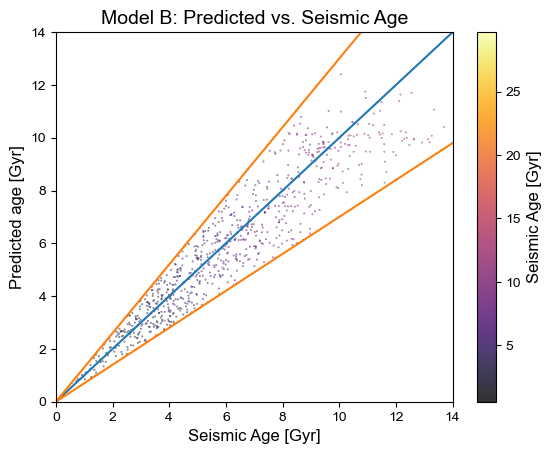

In [81]:
plt.scatter((y_test_B[goodfitB] * scaling_y), (predictionsB[goodfitB] * scaling_y),c = (y_test_B[goodfitB] * scaling_y), cmap='inferno', s=0.1, alpha=0.8)
plt.xlim(0., 14.)
plt.plot([0., 14.], [0., 14.])
plt.plot([14, 0, 14], [14 * (1 - metric), 0, 14 * (1 + metric)])
plt.ylabel(r'Predicted age [Gyr]')
plt.xlabel(r'Seismic Age [Gyr]')
plt.ylim(0, 14)
plt.title("Model B: Predicted vs. Seismic Age")
cbar = plt.colorbar()
cbar.set_label("Seismic Age [Gyr]")
plt.savefig("ModelB_Predicted_vs_SeismicAge.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [83]:
test_ids = apokasc3_matched['KIC'][testing]
print("Number of KIC IDs set:", len(test_ids))

Number of KIC IDs set: 1189


In [85]:
true_ages = (y_test * scaling_y).flatten()
predA_real = (predictionsA * scaling_y).flatten()

In [87]:
test_ids_fixed = test_ids[:len(predA_real)]
true_ages_fixed = true_ages[:len(predA_real)]
predA_fixed = predA_real

In [89]:
tableA = Table()
tableA['KIC'] = test_ids_fixed
tableA['Seismic_Age_Gyr'] = true_ages_fixed
tableA['ModelA_PredAge_Gyr'] = predA_fixed
tableA[:5]

KIC,Seismic_Age_Gyr,ModelA_PredAge_Gyr
int64,float64,float64
11302988,4.3742,4.349757159042358
11303381,6.545499999999999,3.5569822669267652
11303425,6.3475,5.568843428611755
11304158,5.7248,5.512314451169967
11304421,3.1933,2.4450935439467427


In [91]:
true_ages_B = (y_test_B * scaling_y).flatten()
predB_real  = (predictionsB * scaling_y).flatten()

In [93]:
N = len(predA_real)
test_ids_fixed  = test_ids[:N]
true_ages_fixed = true_ages[:N]
predA_fixed     = predA_real[:N]
predB_fixed     = predB_real[:N]

In [95]:
tableB = Table()
tableB['KIC'] = test_ids_fixed
tableB['Seismic_Age_Gyr'] = true_ages_fixed
tableB['ModelB_PredAge_Gyr'] = predB_fixed
tableB[:5]

KIC,Seismic_Age_Gyr,ModelB_PredAge_Gyr
int64,float64,float64
11302988,4.3742,6.095189242482185
11303381,6.545499999999999,2.6776762921929356
11303425,6.3475,9.631435039067268
11304158,5.7248,4.84413835581541
11304421,3.1933,7.448342378735542


In [97]:
combined_table = Table()
combined_table['KIC'] = test_ids_fixed
combined_table['True_Age_Gyr'] = true_ages_fixed
combined_table['ModelA'] = predA_fixed
combined_table['ModelB'] = predB_fixed
combined_table['Difference_B_minus_A'] = predB_fixed - predA_fixed
combined_table[:5]

KIC,True_Age_Gyr,ModelA,ModelB,Difference_B_minus_A
int64,float64,float64,float64,float64
11302988,4.3742,4.349757159042358,6.095189242482185,1.7454320834398267
11303381,6.545499999999999,3.5569822669267652,2.6776762921929356,-0.8793059747338297
11303425,6.3475,5.568843428611755,9.631435039067268,4.062591610455513
11304158,5.7248,5.512314451169967,4.84413835581541,-0.668176095354557
11304421,3.1933,2.4450935439467427,7.448342378735542,5.003248834788799


In [99]:
avg_diff = np.mean(combined_table['Difference_B_minus_A'])
std_diff = np.std(combined_table['Difference_B_minus_A'])
print("Average difference (B − A):", avg_diff)
print("Standard deviation:", std_diff)

Average difference (B − A): 0.10171266085690273
Standard deviation: 4.622294685391555


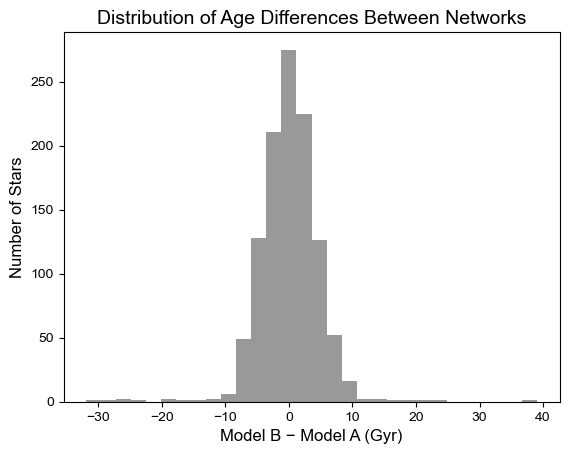

In [103]:
plt.hist(combined_table['Difference_B_minus_A'], bins=30, color='grey',alpha=0.8)
plt.xlabel("Model B − Model A (Gyr)")
plt.ylabel("Number of Stars")
plt.title("Distribution of Age Differences Between Networks")
plt.savefig("AgeDifference_Distribution.png", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()